<a href="https://colab.research.google.com/github/pdrzxzz/satellite-image-classification/blob/main/satellite_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install joblib, kaggle

In [254]:
# ============================== #
#         Import Libraries       #
# ============================== #

# Essential libraries for machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing libraries from skimage
from skimage import img_as_ubyte
from skimage.io import imread  # To read image files
from skimage.transform import resize  # To resize images
from skimage.feature import hog, local_binary_pattern  # To extract HOG (Histogram of Oriented Gradients) features from images
from skimage.measure import regionprops
from skimage import filters # sobel, prewitt...

# Scikit-learn Data processing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Scikit-learn modules for training and evaluation
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Utilities
import kagglehub  # To download datasets directly from Kaggle using KaggleHub
import os  # For interacting with the operating system, such as file paths
import joblib # Save models

In [288]:
# ========================================== #
#      Constants and Configurations          #
# ========================================== #

# Features to be extracted from images
FEATURES = ['gray', 'color', 'lbp', 'sobel']

# Number of images to use from each class (can be limited for faster runs or place a huge value to use all the images)
NUM_IMAGES_PER_CLASS = 1000000000

# Size to which all images will be resized (width, height)
IMAGE_SIZE = (64, 64)

# Parameters for Local Binary Patterns (LBP)
LBP_RADIUS = 1                  # Radius of circle for LBP
LBP_N_POINTS = 8 * LBP_RADIUS  # Number of points to consider in LBP

# Random state for reproducibility in splitting and models
RANDOM_STATE = 0


In [273]:
# ============================== #
#        Download Dataset        #
# ============================== #

# Download dataset from Kaggle using KaggleHub
path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")

# Path to the folder containing the image dataset
data_path = os.path.join(path, "data")

# List all image classes (subdirectories) in the dataset folder, sorted for consistency
image_classes = sorted(os.listdir(data_path))

# Print dataset location and classes found for confirmation
print("Dataset directory:", data_path)
print("Classes found:", image_classes)

Dataset directory: /kaggle/input/satellite-image-classification/data
Classes found: ['cloudy', 'desert', 'green_area', 'water']


In [274]:
# ========================================== #
#      Image Processing & Feature Utils      #
# ========================================== #

def load_and_resize_image(image_path, as_gray=True):
    """
    Load an image from a file and resize it to a fixed size.

    Parameters:
    - image_path (str): Path to the image file.
    - as_gray (bool): Load the image as grayscale if True; else as color.

    Returns:
    - np.ndarray: Resized image array.
    """
    # Load image with or without grayscale
    image = imread(image_path, as_gray=as_gray)

    # Resize image to fixed dimensions with anti-aliasing to smooth the result
    resized_image = resize(image, IMAGE_SIZE, anti_aliasing=True)
    return resized_image

def extract_color_histograms(image):
    """
    Extract 256-bin histogram features for each RGB channel and concatenate.

    Parameters:
    - image (np.ndarray): Color image array.

    Returns:
    - np.ndarray: Concatenated histogram vector (length 256 * 3 = 768).
    """
    # For each color channel (R,G,B), compute histogram counts
    histograms = [
        np.histogram(image[:, :, channel], bins=256, range=(0, 256))[0]
        for channel in range(3)
    ]
    # Concatenate histograms of all channels into one feature vector
    concatenated_hist = np.concatenate(histograms)
    return concatenated_hist

def extract_lbp_features(gray_image):
    """
    Compute Local Binary Pattern (LBP) histogram for a grayscale image.

    Parameters:
    - gray_image (np.ndarray): Grayscale image array.

    Returns:
    - np.ndarray: Normalized histogram of LBP patterns.
    """
    # Convert grayscale image to unsigned 8-bit format (required by LBP)
    image_uint8 = img_as_ubyte(gray_image)

    # Compute LBP using 'uniform' method
    lbp = local_binary_pattern(image_uint8, LBP_N_POINTS, LBP_RADIUS, method="uniform")

    # Define number of bins for histogram
    n_bins = LBP_N_POINTS + 2  # Number of possible LBP patterns in uniform method

    # Calculate normalized histogram of LBP
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    return lbp_hist

In [275]:
# ========================================== #
#          Dataset Feature Extraction        #
# ========================================== #

def process_dataset(features=["gray"]):
    """
    Load dataset images, extract selected features and encode labels.

    Parameters:
    - features (list of str): Feature types to extract.
        Options include 'gray', 'color', 'lbp', 'sobel', 'prewitt'.

    Returns:
    - X (np.ndarray): Feature matrix of shape (num_samples, num_features).
    - y (np.ndarray): Encoded integer labels for each sample.
    """
    # Dictionary to hold lists of extracted features per feature type
    feature_arrays = {f: [] for f in features}

    # List to store string labels (class names)
    labels = []

    # Iterate over each class folder
    for image_class in image_classes:
        print(f"Processing class: {image_class}")
        class_path = os.path.join(data_path, image_class)

        # List all image files in the class folder, limit by NUM_IMAGES_PER_CLASS
        image_list = os.listdir(class_path)[:NUM_IMAGES_PER_CLASS]

        # Process each image file in the current class
        for idx, image_file in enumerate(image_list):
            img_path = os.path.join(class_path, image_file)

            # Load grayscale image resized to fixed size
            gray = load_and_resize_image(img_path, as_gray=True)

            # Append class label string to labels list
            labels.append(image_class)

            # Extract and append grayscale flattened pixels if requested
            if "gray" in features:
                feature_arrays["gray"].append(gray.flatten())

            # Extract and append color histograms if requested
            if "color" in features:
                color_img = imread(img_path)
                feature_arrays["color"].append(extract_color_histograms(color_img))

            # Extract and append LBP histogram if requested
            if "lbp" in features:
                feature_arrays["lbp"].append(extract_lbp_features(gray))

            # Extract and append Sobel edge features if requested
            if "sobel" in features:
                sobel_img = filters.sobel(gray)
                feature_arrays["sobel"].append(sobel_img.flatten())

            # Extract and append Prewitt edge features if requested
            if "prewitt" in features:
                prewitt_img = filters.prewitt(gray)
                feature_arrays["prewitt"].append(prewitt_img.flatten())

            # Progress print on the same line for convenience
            print(f"\r{idx + 1}/{len(image_list)}", end="", flush=True)
        print()  # New line after finishing a class

    # Encode string labels to integers (e.g., "forest"->0, "urban"->1, etc.)
    labels_encoded = LabelEncoder().fit_transform(labels)

    # List to hold scaled feature arrays for each requested feature type
    scaled_features = []

    # Normalize each feature array independently using StandardScaler (mean=0, std=1)
    for f in features:
        array = np.array(feature_arrays[f])
        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(array)
        scaled_features.append(scaled_array)

    # Concatenate features horizontally if multiple feature types requested
    if len(scaled_features) > 1:
        X = np.concatenate(scaled_features, axis=1)
    else:
        X = scaled_features[0]

    # Return final feature matrix and encoded labels as numpy arrays
    return X, labels_encoded

In [285]:
# ========================================== #
#      Model Evaluation and Visualization    #
# ========================================== #
def personalized_confusion_matrix(model_name, y_true, y_pred, ax, cmap='Greens'):
    """
    Plot confusion matrix heatmap with counts and percentages annotated.

    Parameters:
    - model_name (str): Model title for the plot.
    - y_true (array-like): Ground truth labels.
    - y_pred (array-like): Predicted labels.
    - ax (matplotlib.axes.Axes): Axis to plot on.
    - cmap (str): Colormap for heatmap.
    """
    # Compute confusion matrix counts
    cm = confusion_matrix(y_true, y_pred)

    # Calculate percentages per cell relative to total predictions
    total = cm.sum()
    percentages = cm / total * 100

    # Prepare annotation strings combining counts and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n{percentages[i, j]:.1f}%'

    # Create DataFrame for better visualization labels
    df_cm = pd.DataFrame(cm,
                         index=[f'Actual: {i}' for i in range(cm.shape[0])],
                         columns=[f'Predicted: {i}' for i in range(cm.shape[1])])

    # Plot heatmap with annotations, fixed color scale max for better comparison
    sns.heatmap(df_cm, annot=annot, fmt="", cmap=cmap, cbar=False, ax=ax, vmin=0)

    # Set y-axis labels horizontal for better readability
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(f"Confusion Matrix: {model_name}")

def personalized_classification_report(model_name, y_true, y_pred, ax, cmap='Greens'):
    """
    Plot classification report heatmap (precision, recall, f1-score).

    Parameters:
    - model_name (str): Model title for the plot.
    - y_true (array-like): Ground truth labels.
    - y_pred (array-like): Predicted labels.
    - ax (matplotlib.axes.Axes): Axis to plot on.
    - cmap (str): Colormap for heatmap.
    """
    # Generate classification report dictionary (excluding accuracy)
    clf_report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    clf_report.pop("accuracy", None)  # remove overall accuracy entry

    # Convert to DataFrame and transpose for heatmap visualization
    df_report = pd.DataFrame(clf_report).iloc[:-1, :].T  # remove support column

    # Plot heatmap with values annotated, colormap from 0.7 to 1 for metrics
    sns.heatmap(df_report, annot=True, vmin=0.7, vmax=1, cmap=cmap, cbar=False, ax=ax)

    # Set plot title with bold font
    ax.set_title(f"Classification Report: {model_name}", weight='bold')

    # Calculate overall accuracy and display it as text below the plot
    accuracy = accuracy_score(y_true, y_pred)
    ax.text(0.5, -0.3, f'Accuracy: {accuracy:.2f}', ha='center', va='center', fontsize=10, transform=ax.transAxes)


def evaluate_classifier(model, model_name, X_train, X_test, y_train, y_test,
                        classification_axes, confusion_matrix_axes, cmap='Greens'):
    """
    Fit the model, predict on train/test sets, and plot classification reports and confusion matrices.

    Parameters:
    - model (estimator): Scikit-learn estimator object.
    - model_name (str): Name for labeling plots.
    - X_train, X_test (np.ndarray): Training and testing feature matrices.
    - y_train, y_test (np.ndarray): Training and testing labels.
    - classification_axes (list): Two matplotlib axes for classification report plots (train, test).
    - confusion_matrix_axes (list): Two matplotlib axes for confusion matrix plots (train, test).
    - cmap (str): Colormap name.
    """
    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict labels on both training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Plot classification report for training and testing sets
    personalized_classification_report(f"{model_name} (Train)", y_train, y_train_pred, ax=classification_axes[0], cmap=cmap)
    personalized_classification_report(f"{model_name} (Test)", y_test, y_test_pred, ax=classification_axes[1], cmap=cmap)

    # Plot confusion matrices for training and testing sets
    personalized_confusion_matrix(f"{model_name} (Train)", y_train, y_train_pred, ax=confusion_matrix_axes[0], cmap=cmap)
    personalized_confusion_matrix(f"{model_name} (Test)", y_test, y_test_pred, ax=confusion_matrix_axes[1], cmap=cmap)

def compare_classifiers(models, model_names, X_train, X_test, y_train, y_test,
                        title="Classifier Comparison", cmap="Greens"):
    """
    Evaluate multiple classifiers on the same data and plot their results side-by-side.

    Parameters:
    - models (list): List of sklearn estimators.
    - model_names (list): List of model names corresponding to models.
    - X_train, X_test, y_train, y_test: Dataset splits.
    - title (str): Overall figure title.
    - cmap (str): Colormap for heatmaps.
    """
    num_models = len(models)
    assert num_models == len(model_names), "Models and names count mismatch"
    assert num_models <= 4, "Supports up to 4 models for clear plotting"

    # Create a grid of 4 rows and 'num_models' columns of subplots
    fig, axs = plt.subplots(4, num_models, figsize=(num_models * 5, 12))

    # For each model, generate classification and confusion matrix plots
    for idx, (model, name) in enumerate(zip(models, model_names)):
        classification_axes = [axs[0, idx], axs[1, idx]]  # top two rows: train/test classification report
        confusion_matrix_axes = [axs[2, idx], axs[3, idx]] # bottom two rows: train/test confusion matrix

        evaluate_classifier(model, name, X_train, X_test, y_train, y_test,
                            classification_axes, confusion_matrix_axes, cmap=cmap)

    # Set the overall figure title and bottom annotation
    fig.suptitle(title, fontsize=20, weight="bold")
    fig.text(0.5, 0.015,
             "Top rows = Classification Reports (Train/Test) | Bottom rows = Confusion Matrices (Train/Test)",
             ha='center', fontsize=10)

    plt.tight_layout(rect=[0, 0.04, 1, 0.95])
    plt.show()


from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, title="Learning Curve", scoring="accuracy", cv_splits=5):
    """
    Plot the learning curve for a given model and dataset.

    Parameters:
    - model (estimator): A scikit-learn estimator (e.g., RandomForestClassifier).
    - X (np.ndarray): Feature matrix.
    - y (np.ndarray): Target labels.
    - title (str): Title for the plot.
    - scoring (str): Metric to evaluate model performance (default = 'accuracy').
    - cv_splits (int): Number of cross-validation folds.
    """
    # Create a stratified K-fold split strategy
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)

    # Define relative sizes of training data to evaluate
    train_sizes = np.linspace(0.05, 0.95, 19)

    # Compute training and validation scores for different training sizes
    train_sizes_abs, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        shuffle=True,
        random_state=RANDOM_STATE
    )

    # Compute mean and standard deviation for error bands
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes_abs, train_mean, 'o-', label='Training Accuracy', color='blue')
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

    plt.plot(train_sizes_abs, val_mean, 'o-', label='Validation Accuracy', color='green')
    plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

    # X-axis in percentage form for clarity
    percent_labels = [f"{int(p * 100)}%" for p in train_sizes]
    plt.xticks(train_sizes_abs, percent_labels, rotation=45)

    # Set plot titles and labels
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel("Training Set Size (%)")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [280]:
# ========================================== #
#           Training and Evaluation          #
# ========================================== #

def train_and_evaluate(X, y, description):
    """
    Splits dataset, trains multiple classifiers, and compares their performance.

    Parameters:
    - X (np.ndarray): Feature matrix.
    - y (np.ndarray): Labels.
    - description (str): Title for comparison plots.
    """
    # Split dataset into train and test sets with stratification and fixed random state
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

    # Define models to train
    models = [
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        GaussianNB(),
        KNeighborsClassifier(),
        RandomForestClassifier(random_state=RANDOM_STATE)
    ]

    model_names = ["Decision Tree", "Naive Bayes", "KNN", "Random Forest"]

    # Compare classifiers side by side
    compare_classifiers(models, model_names, X_train, X_test, y_train, y_test, title=description)


def train_grid_search(X, y):
    """
    Perform hyperparameter tuning with GridSearchCV on RandomForestClassifier.

    Parameters:
    - X (np.ndarray): Feature matrix.
    - y (np.ndarray): Labels.

    Returns:
    - best_model (estimator): Best estimator after grid search.
    """
    # Split dataset for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

    # Define hyperparameter grid for Random Forest
    param_grid = {
        'n_estimators': [50, 100, 200],            # Number of trees
        'max_depth': [None, 10, 20, 30],           # Max depth of trees
        'min_samples_split': [2, 5, 10],           # Min samples required to split node
        'min_samples_leaf': [1, 2, 4],             # Min samples required at leaf node
        'max_features': ['sqrt', 'log2'],          # Number of features to consider at each split
        'bootstrap': [True, False]                  # Whether bootstrap samples are used when building trees
    }

    # Initialize Random Forest model with fixed random state for reproducibility
    rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

    # Define cross-validation scheme with stratified k-fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # Setup GridSearchCV to find best hyperparameters
    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        scoring='accuracy',
        n_jobs=-1,          # Use all CPU cores
        cv=cv,
        verbose=1
    )

    # Fit grid search to training data
    grid_search.fit(X_train, y_train)

    # Print best parameters and test accuracy for best model
    print("Best hyperparameters found:", grid_search.best_params_)
    test_accuracy = accuracy_score(y_test, grid_search.best_estimator_.predict(X_test))
    print(f"Test accuracy with best model: {test_accuracy:.4f}")

    # Return the best model found by grid search
    return grid_search.best_estimator_

Processing class: cloudy
1500/1500
Processing class: desert
1131/1131
Processing class: green_area
1500/1500
Processing class: water
1500/1500


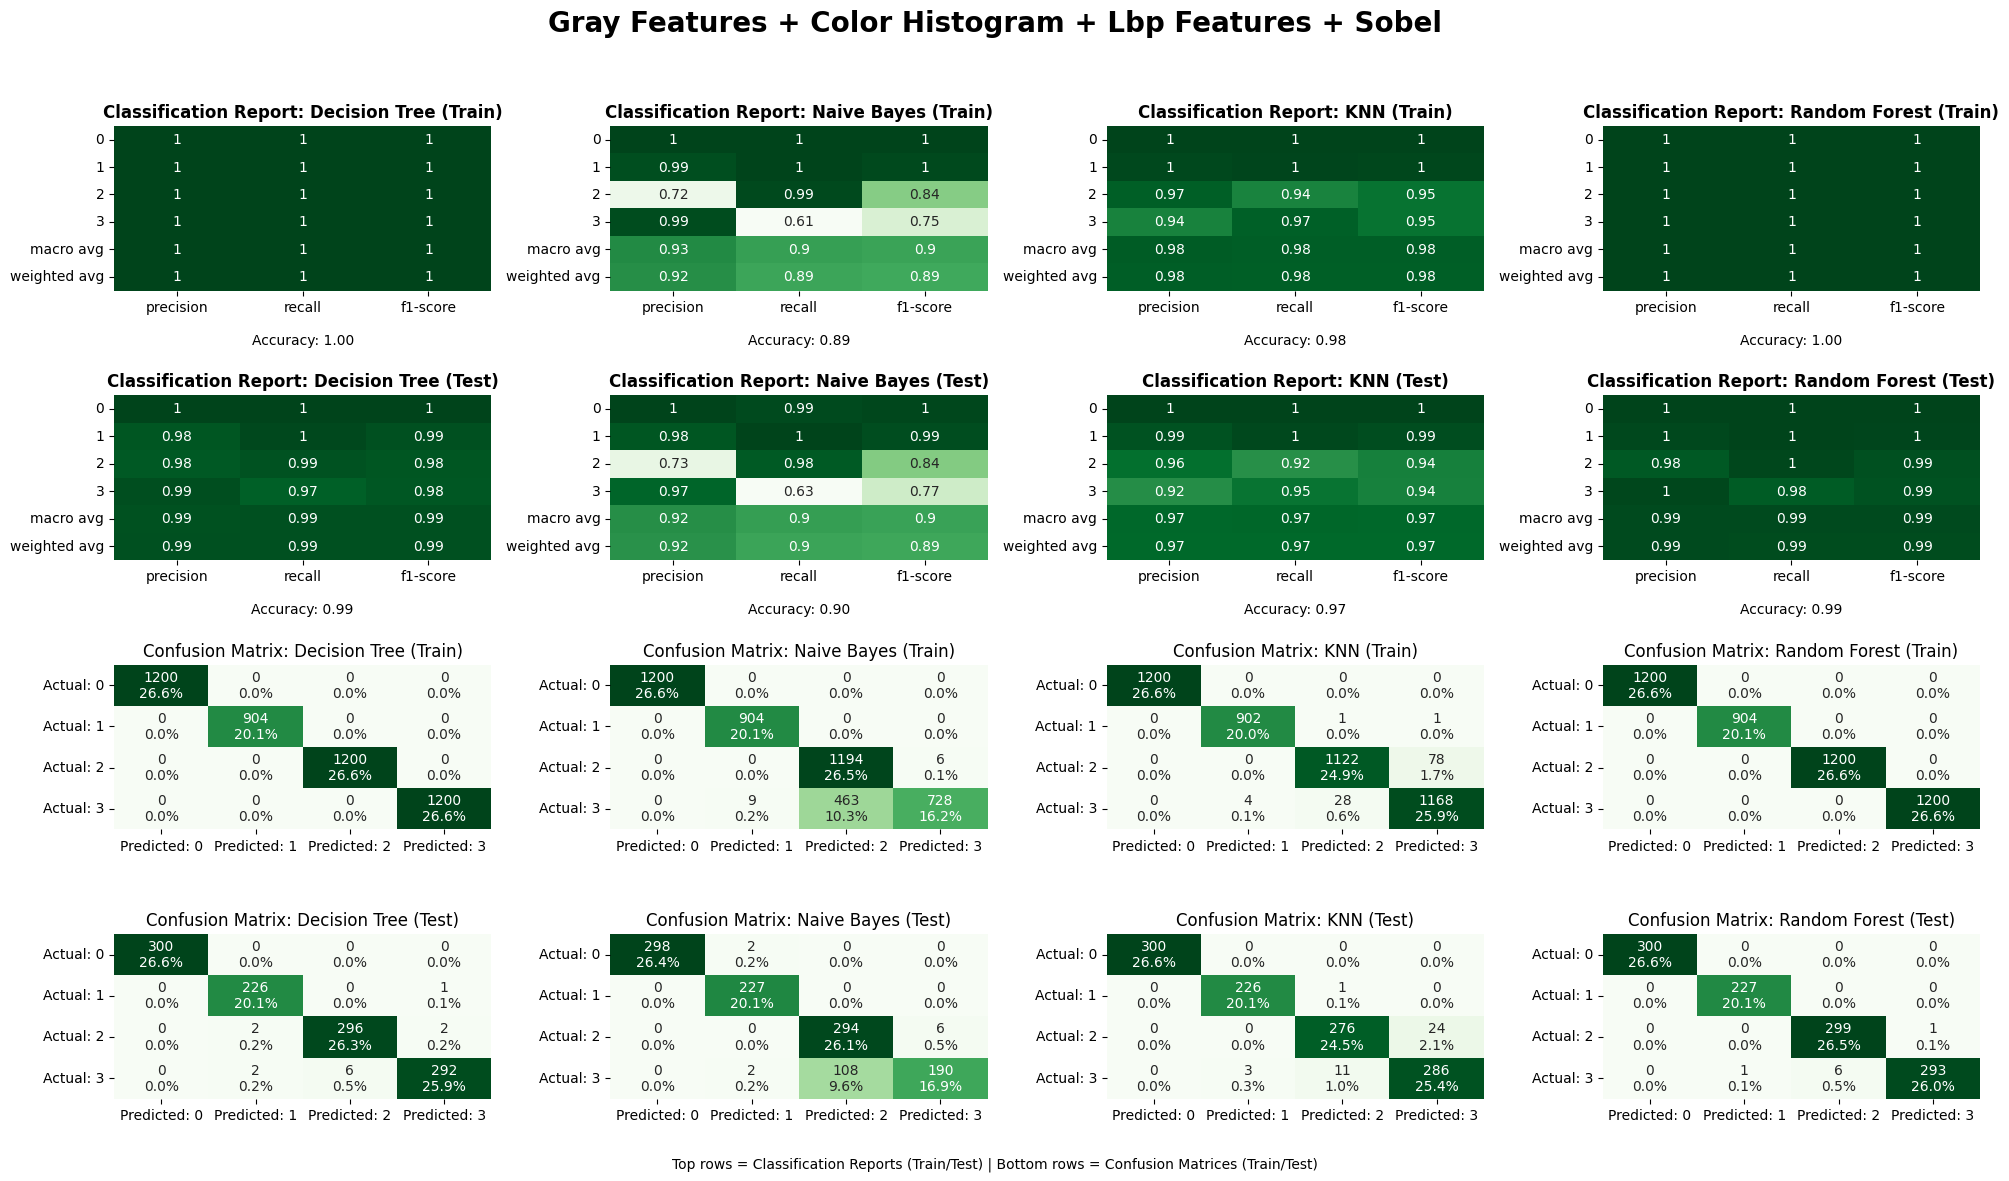

In [ ]:
# ========================================== #
#                Run Pipeline                #
# ========================================== #

# Process dataset once
X, y = process_dataset(FEATURES)

# Create descriptive title for feature combination
feature_names = []
for f in FEATURES:
    if f == "color":
        feature_names.append("Color Histogram")
    elif f in ["gray", "lbp"]:
        feature_names.append(f.capitalize() + " Features")
    else:
        feature_names.append(f.capitalize())
title = " + ".join(feature_names)

# Train and compare multiple classifiers
train_and_evaluate(X, y, title)

# Plot learning curve for Random Forest using same data
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model.fit(X, y)
plot_learning_curve(rf_model, X, y, title="Random Forest - Learning Curve")

joblib.dump(rf_model, 'random_forest_model.joblib')
